In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, wasserstein_distance, multivariate_normal
from scipy.linalg import qr
from math import sqrt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

### 1. Configuration


In [2]:
# Set random seed for reproducibility
np.random.seed(1)

# Dimensions
d = 100  # Ambient dimension
k = 10  # Principal subspace dimension
m = d - k  # Orthogonal complement dimension

# Mixture parameters
alpha = 0.9  # Mixture weight for normal distribution (D0)

# Sample sizes
n_train = 100_000
n_calibration = 10_000
n_test = 100_000

# Covariance parameters
variance_normal_base = 50.0
variance_abnormal_base = 100.0
decay_rate = 0.95  # Exponential decay rate

# Mean shift parameters
a_in = 0.2  # Magnitude inside principal subspace
a_out = 0.1  # Magnitude outside principal subspace

### 2. Helper Functions


In [3]:
def create_basis(dimension, seed=1):
    """Create an orthonormal basis using QR decomposition."""
    rng = np.random.RandomState(seed)
    A = rng.randn(dimension, dimension)
    Q, _ = qr(A)
    return Q


def create_covariance(base_variance, decay_rate, dimension, basis):
    """Create a covariance matrix with exponentially decaying eigenvalues."""
    variances = base_variance * (decay_rate ** np.arange(dimension))
    D = np.diag(variances)
    return basis @ D @ basis.T


def build_delta(Q, k, a_in, a_out):
    """Construct mean shift vector with components in and out of principal subspace."""
    # Component inside principal subspace
    V_k = Q[:, :k]
    coeffs_in = a_in * np.ones(k) / np.sqrt(k)
    delta_in = V_k @ coeffs_in

    # Component outside principal subspace
    Q_perp = Q[:, k:]
    m = Q_perp.shape[1]
    rand_coeffs_out = np.random.randn(m)
    rand_coeffs_out /= np.linalg.norm(rand_coeffs_out)
    delta_out = Q_perp @ (a_out * rand_coeffs_out)

    return delta_in + delta_out


### 3. Setup Distributions


In [4]:
# Create orthonormal bases
basis_normal = create_basis(d, seed=3)
basis_abnormal = create_basis(d, seed=4)

# Define principal subspace and projection matrices
V_k = basis_normal[:, :k]
P_oracle = V_k @ V_k.T  # Projection onto principal subspace
R_oracle = np.eye(d) - P_oracle  # Projection onto orthogonal complement

# Create covariance matrices
Sigma1 = create_covariance(variance_normal_base, decay_rate, d, basis_normal)
Sigma2 = create_covariance(variance_abnormal_base, decay_rate, d, basis_abnormal)

# Define means
mu1 = np.zeros(d)
Delta = build_delta(basis_normal, k, a_in, a_out)
mu2 = mu1 + Delta

# Configuration Summary
print("=" * 60)
print("CONFIGURATION SUMMARY")
print("=" * 60)
print(f"Dimensions: d={d}, k={k}, m={m}")
print(f"Sample Sizes: Train={n_train:,}, Calib={n_calibration:,}, Test={n_test:,}")
print(f"Mixture: α={alpha}")
print(f"Mean Shift (Delta):")
print(f"  • Inside subspace: {np.linalg.norm(V_k.T @ Delta):.4f}")
print(f"  • Outside subspace: {np.linalg.norm(R_oracle @ Delta):.4f}")
print(f"  • Total magnitude: {np.linalg.norm(Delta):.4f}")
print("=" * 60)


CONFIGURATION SUMMARY
Dimensions: d=100, k=10, m=90
Sample Sizes: Train=100,000, Calib=10,000, Test=100,000
Mixture: α=0.9
Mean Shift (Delta):
  • Inside subspace: 0.2000
  • Outside subspace: 0.1000
  • Total magnitude: 0.2236


### 4. Data Generation


In [5]:
def generate_mix_dataset(mu1, mu2, Sigma1, Sigma2, n_samples, alpha):
    """Generate mixed dataset from two Gaussian distributions."""
    n_normal = int(n_samples * alpha)
    n_abnormal = n_samples - n_normal

    X_normal = np.random.multivariate_normal(mean=mu1, cov=Sigma1, size=n_normal)
    X_abnormal = np.random.multivariate_normal(mean=mu2, cov=Sigma2, size=n_abnormal)

    X = np.vstack([X_normal, X_abnormal])
    y = np.hstack([np.zeros(n_normal), np.ones(n_abnormal)])

    # Shuffle
    indices = np.random.permutation(n_samples)
    return X[indices], y[indices]


# Generate datasets
print("Generating datasets...")
X_cal, y_cal = generate_mix_dataset(mu1, mu2, Sigma1, Sigma2, n_calibration, alpha)
X_test, y_test = generate_mix_dataset(mu1, mu2, Sigma1, Sigma2, n_test, alpha)
print(f"✓ Calibration set: {len(y_cal)} samples ({np.sum(y_cal == 0)} normal, {np.sum(y_cal == 1)} abnormal)")
print(f"✓ Test set: {len(y_test)} samples ({np.sum(y_test == 0)} normal, {np.sum(y_test == 1)} abnormal)")

Generating datasets...
✓ Calibration set: 10000 samples (9000 normal, 1000 abnormal)
✓ Test set: 100000 samples (90000 normal, 10000 abnormal)


### 5. Anomaly Detection Methods


In [6]:
def compute_errors(X, R, mu1):
    """Compute reconstruction errors using residual projection."""
    centered = X - mu1
    residuals = centered @ R
    return np.sum(residuals ** 2, axis=1)


def predict(X, R, mu1, threshold):
    """Predict labels based on error threshold."""
    errors = compute_errors(X, R, mu1)
    return (errors >= threshold).astype(int)


def empirical_loss(X, y, R, mu1, threshold):
    """Compute 0-1 loss on dataset."""
    y_pred = predict(X, R, mu1, threshold)
    return np.mean(y_pred != y)


def calibrate_threshold(X_cal, y_cal, R, mu1):
    """Find optimal threshold by minimizing empirical loss on calibration set."""
    errors = compute_errors(X_cal, R, mu1)
    unique_errors = np.sort(np.unique(errors))

    if len(unique_errors) == 0:
        return 0.0

    # Include a point slightly beyond the maximum for completeness
    candidates = np.append(unique_errors, unique_errors[-1] * 1.0001)

    best_loss = float('inf')
    best_threshold = 0.0

    for tau in candidates:
        y_pred = (errors >= tau).astype(int)
        loss = np.sum(y_pred != y_cal)

        if loss < best_loss or (loss == best_loss and tau < best_threshold):
            best_loss = loss
            best_threshold = tau
    
    return best_threshold

def compute_true_bayes_error(mu1, Sigma1, mu2, Sigma2, alpha, n_samples=100_000):
    """
    Estimate the true Bayes error on the original d-dimensional distributions
    by Monte Carlo simulation.
    """
    # 1. Generate a large dataset from the true mixture
    X_bayes, y_bayes = generate_mix_dataset(mu1, mu2, Sigma1, Sigma2, n_samples, alpha)
    
    # 2. Create the log-pdf functions for each class
    try:
        logpdf_0 = multivariate_normal(mean=mu1, cov=Sigma1).logpdf
        logpdf_1 = multivariate_normal(mean=mu2, cov=Sigma2).logpdf
    except np.linalg.LinAlgError as e:
        print(f"Warning: LinAlgError during Bayes error calculation: {e}")
        return np.nan
    
    # 3. Compute log-likelihoods
    ll_0 = logpdf_0(X_bayes)
    ll_1 = logpdf_1(X_bayes)
    
    # 4. Compute log-priors
    log_prior_0 = np.log(alpha)
    log_prior_1 = np.log(1.0 - alpha)
    
    # 5. Compute posterior log-probabilities (unnormalized)
    log_posterior_0 = ll_0 + log_prior_0
    log_posterior_1 = ll_1 + log_prior_1
    
    # 6. Make Bayes optimal prediction
    # Predict 1 if log_posterior_1 > log_posterior_0
    y_pred_bayes = (log_posterior_1 > log_posterior_0).astype(int)
    
    # 7. Calculate the error
    error_rate = np.mean(y_pred_bayes != y_bayes)
    return error_rate

### 6. Theoretical Analysis (Gaussian Approximation)


In [7]:
def theoretical_params(Sigma1, Sigma2, R_oracle, Delta):
    """Compute theoretical parameters of error distributions (Gaussian approx.)."""
    mu1p = np.trace(R_oracle @ Sigma1)
    sigma1p2 = 2 * np.trace(R_oracle @ Sigma1 @ R_oracle @ Sigma1)

    mu2p = np.trace(R_oracle @ Sigma2) + np.linalg.norm(R_oracle @ Delta) ** 2
    sigma2p2 = (2 * np.trace(R_oracle @ Sigma2 @ R_oracle @ Sigma2) +
                4 * (Delta.T @ R_oracle @ Sigma2 @ R_oracle @ Delta))

    return mu1p, sigma1p2, mu2p, sigma2p2


def solve_tau_star(mu1p, sigma1p2, mu2p, sigma2p2, alpha):
    """Solve for optimal threshold tau* under Gaussian approximation."""
    sigma1p = np.sqrt(sigma1p2)
    sigma2p = np.sqrt(sigma2p2)

    # Solve quadratic equation from setting derivative of loss to 0
    A_quad = 1.0 / sigma2p2 - 1.0 / sigma1p2
    B_quad = 2.0 * mu1p / sigma1p2 - 2.0 * mu2p / sigma2p2
    C_quad = (mu2p ** 2 / sigma2p2 - mu1p ** 2 / sigma1p2 +
              2.0 * np.log((alpha * sigma2p) / ((1.0 - alpha) * sigma1p)))

    if abs(A_quad) < 1e-12:
        # Linear case
        tau_candidates = np.array([-C_quad / B_quad]) if abs(B_quad) > 1e-12 else np.array([])
    else:
        # Quadratic case
        disc = B_quad ** 2 - 4.0 * A_quad * C_quad
        if disc < 0:
            tau_candidates = np.array([])
        else:
            tau_candidates = np.array([
                (-B_quad + np.sqrt(disc)) / (2.0 * A_quad),
                (-B_quad - np.sqrt(disc)) / (2.0 * A_quad)
            ])

    # Select best candidate
    if tau_candidates.size == 0:
        return tau_candidates, None

    # Prefer threshold between the two means
    lo, hi = min(mu1p, mu2p), max(mu1p, mu2p)
    inside = tau_candidates[(tau_candidates > lo - 1e-8) & (tau_candidates < hi + 1e-8)]

    if len(inside) > 0:
        # Choose candidate closest to midpoint
        mid = 0.5 * (lo + hi)
        tau_star = inside[np.argmin(np.abs(inside - mid))]
    else:
        # Choose candidate with minimum theoretical loss
        def L_theo(t):
            return (alpha * (1.0 - norm.cdf((t - mu1p) / sigma1p)) +
                    (1.0 - alpha) * norm.cdf((t - mu2p) / sigma2p))

        losses = np.array([L_theo(t) for t in tau_candidates])
        tau_star = tau_candidates[np.argmin(losses)]

    return tau_candidates, tau_star

### 7. Experiment 1: Calibration and Results


In [8]:
# Empirical threshold calibration
print("Calibrating threshold...")
empirical_threshold = calibrate_threshold(X_cal, y_cal, R_oracle, mu1)
empirical_test_loss = empirical_loss(X_test, y_test, R_oracle, mu1, empirical_threshold)

print(f"\n📍 Empirical Threshold (τ_emp): {empirical_threshold:.4f}")
print(f"   Test Loss (L(τ_emp)): {empirical_test_loss:.6f}")

# Theoretical analysis
mu1p, sigma1p2, mu2p, sigma2p2 = theoretical_params(Sigma1, Sigma2, R_oracle, Delta)
sigma1p = np.sqrt(sigma1p2)
sigma2p = np.sqrt(sigma2p2)

print(f"\n📊 Theoretical Error Distribution Parameters:")
print(f"   Normal (D0):   μ₁' = {mu1p:.4f}, σ₁' = {sigma1p:.4f}")
print(f"   Abnormal (D1): μ₂' = {mu2p:.4f}, σ₂' = {sigma2p:.4f}")

# Solve for optimal threshold
tau_candidates, tau_star = solve_tau_star(mu1p, sigma1p2, mu2p, sigma2p2, alpha)

if tau_star is not None:
    L_pred = (alpha * (1.0 - norm.cdf((tau_star - mu1p) / sigma1p)) +
              (1.0 - alpha) * norm.cdf((tau_star - mu2p) / sigma2p))
    theoretical_test_loss = empirical_loss(X_test, y_test, R_oracle, mu1, tau_star)

    print(f"\n🎯 Theoretical Threshold (τ*): {tau_star:.4f}")
    print(f"   Predicted Loss (L_theo(τ*)): {L_pred:.6f}")
    print(f"   Actual Test Loss (L(τ*)): {theoretical_test_loss:.6f}")
else:
    print("\n⚠️  No valid theoretical threshold found")

Calibrating threshold...

📍 Empirical Threshold (τ_emp): 1123.5492
   Test Loss (L(τ_emp)): 0.004580

📊 Theoretical Error Distribution Parameters:
   Normal (D0):   μ₁' = 592.8164, σ₁' = 135.5806
   Abnormal (D1): μ₂' = 1788.5879, σ₂' = 415.3952

🎯 Theoretical Threshold (τ*): 1022.3398
   Predicted Loss (L_theo(τ*)): 0.003945
   Actual Test Loss (L(τ*)): 0.005980


### 8. Visualization


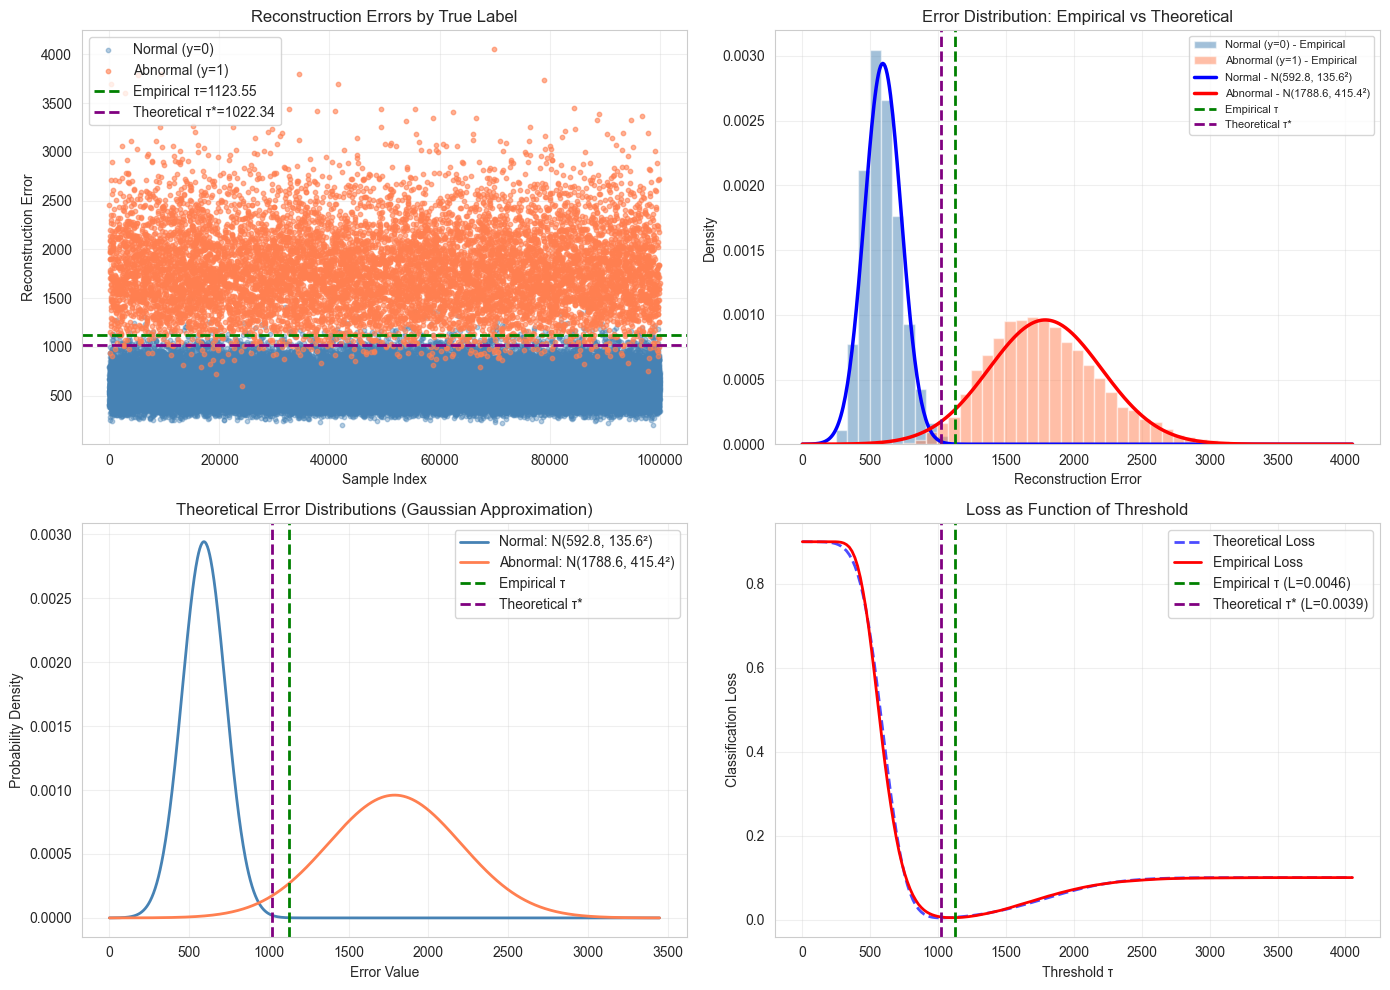

In [9]:
# Compute errors for visualization
errors_test = compute_errors(X_test, R_oracle, mu1)
idx_0 = y_test == 0
idx_1 = y_test == 1

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of errors with theoretical overlay
ax2 = axes[0, 1]
bins = np.linspace(0, max(errors_test), 50)
ax2.hist(errors_test[idx_0], bins=bins, alpha=0.5,
         color='steelblue', label='Normal (y=0) - Empirical', density=True)
ax2.hist(errors_test[idx_1], bins=bins, alpha=0.5,
         color='coral', label='Abnormal (y=1) - Empirical', density=True)

# Overlay theoretical distributions
x_range_hist = np.linspace(0, max(errors_test), 500)
y1_theo = norm.pdf(x_range_hist, mu1p, sigma1p)
y2_theo = norm.pdf(x_range_hist, mu2p, sigma2p)
ax2.plot(x_range_hist, y1_theo, 'b-', linewidth=2.5,
         label=f'Normal - N({mu1p:.1f}, {sigma1p:.1f}²)')
ax2.plot(x_range_hist, y2_theo, 'r-', linewidth=2.5,
         label=f'Abnormal - N({mu2p:.1f}, {sigma2p:.1f}²)')

ax2.axvline(x=empirical_threshold, color='green', linestyle='--',
            linewidth=2, label=f'Empirical τ')
if tau_star is not None:
    ax2.axvline(x=tau_star, color='purple', linestyle='--',
                linewidth=2, label=f'Theoretical τ*')
ax2.set_xlabel('Reconstruction Error')
ax2.set_ylabel('Density')
ax2.set_title('Error Distribution: Empirical vs Theoretical')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 2. Loss curve
ax4 = axes[1, 1]
tau_range = np.linspace(0, max(errors_test), 200)
losses_empirical = [empirical_loss(X_test, y_test, R_oracle, mu1, t) for t in tau_range]
if tau_star is not None:
    losses_theoretical = [alpha * (1.0 - norm.cdf((t - mu1p) / sigma1p)) +
                          (1.0 - alpha) * norm.cdf((t - mu2p) / sigma2p)
                          for t in tau_range]
    ax4.plot(tau_range, losses_theoretical, 'b--', linewidth=2,
             label='Theoretical Loss', alpha=0.7)
ax4.plot(tau_range, losses_empirical, 'r-', linewidth=2, label='Empirical Loss')
ax4.axvline(x=empirical_threshold, color='green', linestyle='--',
            linewidth=2, label=f'Empirical τ (L={empirical_test_loss:.4f})')
if tau_star is not None:
    ax4.axvline(x=tau_star, color='purple', linestyle='--',
                linewidth=2, label=f'Theoretical τ* (L={L_pred:.4f})')
ax4.set_xlabel('Threshold τ')
ax4.set_ylabel('Classification Loss')
ax4.set_title('Loss as Function of Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 3. Scatter plot of errors
ax1 = axes[0, 0]
ax1.scatter(np.where(idx_0)[0], errors_test[idx_0],
            color='steelblue', alpha=0.4, s=10, label='Normal (y=0)')
ax1.scatter(np.where(idx_1)[0], errors_test[idx_1],
            color='coral', alpha=0.6, s=10, label='Abnormal (y=1)')
ax1.axhline(y=empirical_threshold, color='green', linestyle='--',
            linewidth=2, label=f'Empirical τ={empirical_threshold:.2f}')
if tau_star is not None:
    ax1.axhline(y=tau_star, color='purple', linestyle='--',
                linewidth=2, label=f'Theoretical τ*={tau_star:.2f}')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Reconstruction Error')
ax1.set_title('Reconstruction Errors by True Label')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4. Theoretical Gaussian curves
ax3 = axes[1, 0]
x_range = np.linspace(0, max(mu1p + 4 * sigma1p, mu2p + 4 * sigma2p), 1000)
y1_theo = norm.pdf(x_range, mu1p, sigma1p)
y2_theo = norm.pdf(x_range, mu2p, sigma2p)
ax3.plot(x_range, y1_theo, 'steelblue', linewidth=2, label=f'Normal: N({mu1p:.1f}, {sigma1p:.1f}²)')
ax3.plot(x_range, y2_theo, 'coral', linewidth=2, label=f'Abnormal: N({mu2p:.1f}, {sigma2p:.1f}²)')
ax3.axvline(x=empirical_threshold, color='green', linestyle='--',
            linewidth=2, label='Empirical τ')
if tau_star is not None:
    ax3.axvline(x=tau_star, color='purple', linestyle='--',
                linewidth=2, label='Theoretical τ*')
ax3.set_xlabel('Error Value')
ax3.set_ylabel('Probability Density')
ax3.set_title('Theoretical Error Distributions (Gaussian Approximation)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9. Comprehensive Performance Analysis vs. Dimension m

In [10]:
def compute_comprehensive_metrics(X_test, y_test, X_calib, y_calib, R, mu1,
                                Sigma1, Sigma2, Delta, alpha):
    """Compute all metrics for the comprehensive performance table.
    
    Note: This function finds the *empirical optimal* threshold on a
    separate calibration set (hat_tau_star) for a direct comparison against the
    *theoretical optimal* threshold (tau_star). The test set is used only
    for computing the empirical loss.
    """
    
    # Compute errors
    errors = compute_errors(X_test, R, mu1)
    idx_0 = y_test == 0
    idx_1 = y_test == 1
        
    errors_0 = errors[idx_0]
    errors_1 = errors[idx_1]
        
    # Theoretical parameters
    mu1p, sigma1p2, mu2p, sigma2p2 = theoretical_params(Sigma1, Sigma2, R, Delta)
    sigma1p = sqrt(sigma1p2)
    sigma2p = sqrt(sigma2p2)
        
    # 2. Wasserstein distance W_1 (average of both standardized distances)
    # Generate samples from theoretical distributions for comparison
    n_samples = min(10000, len(errors_0), len(errors_1))
    
    # Use a local RNG for reproducibility within the function
    local_rng = np.random.RandomState(seed=42)
    theo_samples_0 = local_rng.normal(mu1p, sigma1p, n_samples)
    theo_samples_1 = local_rng.normal(mu2p, sigma2p, n_samples)
    
    # Compute Wasserstein distances between empirical and theoretical samples
    w1_0 = wasserstein_distance(errors_0[:n_samples], theo_samples_0)
    w1_1 = wasserstein_distance(errors_1[:n_samples], theo_samples_1)
    
    # Normalize each by its own sigma (standardized distances)
    w1_0_std = w1_0 / sigma1p if sigma1p > 0 else np.nan
    w1_1_std = w1_1 / sigma2p if sigma2p > 0 else np.nan
    
    # Mean of the standardized distances
    w1_stat = (w1_0_std + w1_1_std) / 2
        
    # 3. Threshold deviation |hat_tau* - tau*|
    tau_candidates, tau_star = solve_tau_star(mu1p, sigma1p2, mu2p, sigma2p2, alpha)
    # Calibrate on the CALIBRATION set to find the *empirical best* threshold
    hat_tau_star = calibrate_threshold(X_calib, y_calib, R, mu1)
        
    if tau_star is not None:
        tau_deviation = abs(hat_tau_star - tau_star)
        # δτ as percentage: 100 * |τ* - τ̂*| / |τ̂*|
        delta_tau_pct = 100 * tau_deviation / abs(hat_tau_star) if hat_tau_star != 0 else np.nan
    else:
        tau_deviation = np.nan
        delta_tau_pct = np.nan
        
    # 4. Theoretical loss L_01(tau*)
    if tau_star is not None:
        L_theory = (alpha * (1.0 - norm.cdf((tau_star - mu1p) / sigma1p)) +
                    (1.0 - alpha) * norm.cdf((tau_star - mu2p) / sigma2p))
    else:
        L_theory = np.nan
        
    # 5. Empirical loss L_01(hat_tau*) - computed on TEST set
    L_empirical = empirical_loss(X_test, y_test, R, mu1, hat_tau_star)
    
    # NEW: 6. Empirical loss L_01(tau*) - theoretical threshold evaluated on TEST set
    if tau_star is not None:
        L_empirical_tau_star = empirical_loss(X_test, y_test, R, mu1, tau_star)
        # Relative difference between theoretical and empirical thresholds on test data
        loss_diff_thresholds = abs(L_empirical_tau_star - L_empirical) / L_empirical if L_empirical != 0 else np.nan
        loss_diff_thresholds_pct = 100 * loss_diff_thresholds
    else:
        L_empirical_tau_star = np.nan
        loss_diff_thresholds_pct = np.nan
        
    # 7. Bhattacharyya upper bound (Theorem for reconstruction-based classifier)
    mean_diff_sq = (mu2p - mu1p)**2
    sigma_sum = sigma1p2 + sigma2p2
        
    exponential_term = np.exp(-mean_diff_sq / (4 * sigma_sum))
    sqrt_term = np.sqrt(2 * sigma1p * sigma2p / sigma_sum)
        
    bhattacharyya_error_bound = np.sqrt(alpha * (1 - alpha)) * exponential_term * sqrt_term
        
    # ΔL% as percentage: 100 * |L_theory - L_empirical| / L_empirical
    loss_error_pct = 100 * abs(L_theory - L_empirical) / L_empirical if L_empirical != 0 else np.nan
        
    # ΔBhatt as percentage: Bhatt / L_empirical
    delta_bhatt_pct = bhattacharyya_error_bound / L_empirical if L_empirical != 0 else np.nan
        
    return {
        'w1_normalized': w1_stat,
        'tau_star': tau_star,
        'hat_tau_star': hat_tau_star,
        'delta_tau_pct': delta_tau_pct,
        'L_theory': L_theory,
        'L_empirical': L_empirical,
        'L_empirical_tau_star': L_empirical_tau_star,  # NEW
        'loss_diff_thresholds_pct': loss_diff_thresholds_pct,  # NEW
        'loss_error_pct': loss_error_pct,
        'bhattacharyya': bhattacharyya_error_bound,
        'delta_bhatt_pct': delta_bhatt_pct,
        'mu1p': mu1p,
        'mu2p': mu2p,
        'sigma1p': sigma1p,
        'sigma2p': sigma2p
    }

In [11]:
def create_performance_table(k_m_pairs, n_test_per_config=10000, n_calib_per_config=10000,
                             base_config=None, n_runs=10):
    """
    Create comprehensive performance table for different (k, m) configurations.
    """
    if base_config is None:
        base_config = {
            'variance_normal_base': variance_normal_base,
            'variance_abnormal_base': variance_abnormal_base,
            'decay_rate': decay_rate,
            'alpha': alpha,
            'a_in': a_in,
            'a_out': a_out
        }

    results = {key: [] for key in ['k','m','d','w1_normalized','tau_star','hat_tau_star',
                                   'delta_tau_pct','L_theory','L_empirical','L_empirical_tau_star',
                                   'loss_diff_thresholds_pct','loss_error_pct',
                                   'L_bayes','bhattacharyya','delta_bhatt_pct']}

    print(f"\n{'='*100}\nCOMPUTING COMPREHENSIVE PERFORMANCE METRICS\n{'='* 100}")
    print(f"Testing {len(k_m_pairs)} configurations with {n_runs} runs each")
    print(f"  - Calibration set: {n_calib_per_config:,} samples per run")
    print(f"  - Test set: {n_test_per_config:,} samples per run\n")

    for k_val, m_val in k_m_pairs:
        d_val = k_val + m_val
        print(f"Processing k={k_val:3d}, m={m_val:3d} (d={d_val:3d})... ", end='', flush=True)

        run_metrics = {key: [] for key in results.keys() if key not in ['k','m','d']}

        for i in range(n_runs):
            # Basis and projection
            basis_norm = create_basis(d_val, seed=i)
            basis_abn = create_basis(d_val, seed=i + 1)
            P_local = basis_norm[:, :k_val] @ basis_norm[:, :k_val].T
            R_local = np.eye(d_val) - P_local

            # Covariance and mean setup
            Sigma1_local = create_covariance(base_config['variance_normal_base'], base_config['decay_rate'], d_val, basis_norm)
            Sigma2_local = create_covariance(base_config['variance_abnormal_base'], base_config['decay_rate'], d_val, basis_abn)
            mu1_local = np.zeros(d_val)
            Delta_local = build_delta(basis_norm, k_val, base_config['a_in'], base_config['a_out'])
            mu2_local = mu1_local + Delta_local

            # Generate datasets
            X_test_local, y_test_local = generate_mix_dataset(mu1_local, mu2_local, Sigma1_local, Sigma2_local, n_test_per_config, base_config['alpha'])
            X_calib_local, y_calib_local = generate_mix_dataset(mu1_local, mu2_local, Sigma1_local, Sigma2_local, n_calib_per_config, base_config['alpha'])

            # Compute metrics
            metrics = compute_comprehensive_metrics(X_test_local, y_test_local, X_calib_local, y_calib_local,
                                                    R_local, mu1_local, Sigma1_local, Sigma2_local, Delta_local,
                                                    base_config['alpha'])

            # True Bayes error
            L_bayes_local = compute_true_bayes_error(mu1_local, Sigma1_local, mu2_local, Sigma2_local,
                                                     base_config['alpha'], n_samples=n_test_per_config)

            # Store metrics
            for key in run_metrics:
                run_metrics[key].append(metrics[key] if key in metrics else L_bayes_local)

            print(".", end='', flush=True)

        # Aggregate results
        results['k'].append(k_val)
        results['m'].append(m_val)
        results['d'].append(d_val)
        for key in run_metrics:
            results[key].append(np.mean(run_metrics[key]))

        print(f" ✓ (avg L_Bayes: {results['L_bayes'][-1]:.4f})")

    print("\n" + "="*100)
    return results

In [12]:
# Generate the performance table
# Example: vary m while keeping k fixed, or vary both
k_m_configurations = [
    (5, 2), (5, 6), (5, 10), (5, 15), (5, 20), (5, 50), (5, 100), (5, 200), (5, 500)
]

table_results = create_performance_table(k_m_configurations, n_test_per_config=50000,
                                         n_calib_per_config=30000, n_runs=10)


COMPUTING COMPREHENSIVE PERFORMANCE METRICS
Testing 9 configurations with 10 runs each
  - Calibration set: 30,000 samples per run
  - Test set: 50,000 samples per run

Processing k=  5, m=  2 (d=  7)... .......... ✓ (avg L_Bayes: 0.0836)
Processing k=  5, m=  6 (d= 11)... .......... ✓ (avg L_Bayes: 0.0705)
Processing k=  5, m= 10 (d= 15)... .......... ✓ (avg L_Bayes: 0.0572)
Processing k=  5, m= 15 (d= 20)... .......... ✓ (avg L_Bayes: 0.0408)
Processing k=  5, m= 20 (d= 25)... .......... ✓ (avg L_Bayes: 0.0270)
Processing k=  5, m= 50 (d= 55)... .......... ✓ (avg L_Bayes: 0.0002)
Processing k=  5, m=100 (d=105)... .......... ✓ (avg L_Bayes: 0.0000)
Processing k=  5, m=200 (d=205)... .......... ✓ (avg L_Bayes: 0.0000)
Processing k=  5, m=500 (d=505)... Warning: LinAlgError during Bayes error calculation: When `allow_singular is False`, the input matrix must be symmetric positive definite.
. ✓ (avg L_Bayes: nan)



In [13]:
print("\n" + "=" * 140)
print("COMPREHENSIVE PERFORMANCE TABLE (AVERAGED OVER MULTIPLE RUNS)".center(140))
print("=" * 140)

header = (
    f"{'k':>3s} | {'m':>4s} | {'d':>4s} | {'W₁_norm ↓':>10s} | "
    f"{'τ*':>8s} | {'τ̂*':>8s} | {'δτ% ↓':>10s} | "
    f"{'L_theo(τ*)':>12s} | {'L_emp(τ̂*)':>12s} | {'L_emp(τ*)':>12s} | {'ΔLτ% ↓':>10s} | {'ΔL% ↓':>10s} | "
    f"{'L_Bayes ↓':>12s} | {'Bhatt. ↓':>10s} | {'ΔBhatt% ↑':>12s}"
)
print(header)
print("-" * 140)

for i in range(len(table_results['k'])):
    print(
        f"{table_results['k'][i]:3d} | "
        f"{table_results['m'][i]:4d} | "
        f"{table_results['d'][i]:4d} | "
        f"{table_results['w1_normalized'][i]:10.4f} | "
        f"{table_results['tau_star'][i]:8.3f} | "
        f"{table_results['hat_tau_star'][i]:8.3f} | "
        f"{table_results['delta_tau_pct'][i]:10.2f}% | "
        f"{table_results['L_theory'][i]:12.4f} | "
        f"{table_results['L_empirical'][i]:12.4f} | "
        f"{table_results['L_empirical_tau_star'][i]:12.4f} | "
        f"{table_results['loss_diff_thresholds_pct'][i]:10.2f}% | "
        f"{table_results['loss_error_pct'][i]:10.2f}% | "
        f"{table_results['L_bayes'][i]:12.4f} | "
        f"{table_results['bhattacharyya'][i]:10.4f} | "
        f"{table_results['delta_bhatt_pct'][i]:12.2f}"
    )

print("=" * 140)
print("\nNotes:")
print("  • Values shown as mean ± std over multiple runs.")
print("  • W₁_norm = mean standardized Wasserstein distance (averaged over both classes).")
print("  • δτ% = 100 · |τ* − τ̂*| / |τ̂*|  → relative deviation of optimal thresholds.")
print("  • L_emp(τ*) = empirical loss using theoretical threshold on test set.")
print("  • ΔLτ% = 100 · |L_emp(τ*) − L_emp(τ̂*)| / L_emp(τ̂*)  → performance gap between thresholds.")
print("  • ΔL% = 100 · |L_theo − L_emp| / L_emp  → relative error in loss.")
print("  • ΔBhatt% = Bhatt / L_emp  → relative slack in Bhattacharyya bound.")
print("  • L_Bayes is the true Bayes-optimal error in the full d-dimensional space.")



                                       COMPREHENSIVE PERFORMANCE TABLE (AVERAGED OVER MULTIPLE RUNS)                                        
  k |    m |    d |  W₁_norm ↓ |       τ* |      τ̂* |      δτ% ↓ |   L_theo(τ*) |   L_emp(τ̂*) |    L_emp(τ*) |     ΔLτ% ↓ |      ΔL% ↓ |    L_Bayes ↓ |   Bhatt. ↓ |    ΔBhatt% ↑
--------------------------------------------------------------------------------------------------------------------------------------------
  5 |    2 |    7 |     0.3161 |  265.549 |  407.657 |      34.71% |       0.0755 |       0.0945 |       0.1051 |      11.21% |      20.11% |       0.0836 |     0.2399 |         2.54
  5 |    6 |   11 |     0.1875 |  498.407 |  564.199 |      11.62% |       0.0590 |       0.0790 |       0.0821 |       3.95% |      25.28% |       0.0705 |     0.2080 |         2.63
  5 |   10 |   15 |     0.1509 |  656.874 |  705.011 |       6.79% |       0.0495 |       0.0672 |       0.0687 |       2.23% |      26.29% |       0.0572 |     0.1858 |  

In [14]:
print(r"\begin{table}[ht]")
print(r"\centering")
print(r"\caption{Evaluation of Gaussian approximation and classification performance for different residual dimensions $m$.}")
print(r"\label{tab:main_results}")
print(r"\resizebox{\textwidth}{!}{%")
print(r"\begin{tabular}{cccccccccccccc}")  # 15 columns
print(r"\toprule")
print(r"$k$ & $m$ & $d$ & $W_1^{\text{norm}}$ & $\tau^*$ & $\hat{\tau}$ & $\tau_{\text{err}}$ & "
      r"$L(\tau^*)$ & $\hat{L}(\tau^*)$ & $\hat{L}(\hat{\tau})$ & $L_\text{err}$ & "
      r"$L_{\text{Bayes}}$ & Bhatt. & Bhatt. Ratio \\")
print(r"\midrule")

for i in range(len(table_results['k'])):
    # Handle possible missing L_bayes
    l_bayes_str = (f"{table_results['L_bayes'][i]:.4f}" 
                   if not np.isnan(table_results['L_bayes'][i]) 
                   else r"\text{---}")

    print(
        f"{table_results['k'][i]:d} & "
        f"{table_results['m'][i]} & "
        f"{table_results['d'][i]} & "
        f"{table_results['w1_normalized'][i]:.3f} & "
        f"{table_results['tau_star'][i]:.0f} & "
        f"{table_results['hat_tau_star'][i]:.0f} & "
        f"{table_results['delta_tau_pct'][i]:.1f}\\% & "
        f"{table_results['L_theory'][i]:.3f} & "
        f"{table_results['L_empirical_tau_star'][i]:.3f} & "
        f"{table_results['L_empirical'][i]:.3f} & "
        f"{table_results['loss_error_pct'][i]:.2f}\\% & "
        f"{l_bayes_str} & "
        f"{table_results['bhattacharyya'][i]:.3f} & "
        f"{table_results['delta_bhatt_pct'][i]:.2f} \\\\"
    )

print(r"\bottomrule")
print(r"\end{tabular}}")
print(r"\end{table}")


\begin{table}[ht]
\centering
\caption{Evaluation of Gaussian approximation and classification performance for different residual dimensions $m$.}
\label{tab:main_results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{cccccccccccccc}
\toprule
$k$ & $m$ & $d$ & $W_1^{\text{norm}}$ & $\tau^*$ & $\hat{\tau}$ & $\tau_{\text{err}}$ & $L(\tau^*)$ & $\hat{L}(\tau^*)$ & $\hat{L}(\hat{\tau})$ & $L_\text{err}$ & $L_{\text{Bayes}}$ & Bhatt. & Bhatt. Ratio \\
\midrule
5 & 2 & 7 & 0.316 & 266 & 408 & 34.7\% & 0.076 & 0.105 & 0.095 & 20.11\% & 0.0836 & 0.240 & 2.54 \\
5 & 6 & 11 & 0.187 & 498 & 564 & 11.6\% & 0.059 & 0.082 & 0.079 & 25.28\% & 0.0705 & 0.208 & 2.63 \\
5 & 10 & 15 & 0.151 & 657 & 705 & 6.8\% & 0.050 & 0.069 & 0.067 & 26.29\% & 0.0572 & 0.186 & 2.77 \\
5 & 15 & 20 & 0.130 & 804 & 837 & 3.9\% & 0.039 & 0.054 & 0.053 & 27.07\% & 0.0408 & 0.158 & 2.97 \\
5 & 20 & 25 & 0.111 & 914 & 947 & 3.5\% & 0.031 & 0.043 & 0.043 & 26.70\% & 0.0270 & 0.136 & 3.20 \\
5 & 50 & 55 & 0.099 & 1197 & 1237 & 3.